In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np
# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


In [2]:
n_qubits = 4                     
quantum = False                  
                                 
classical_model = '551_512_2'     
step = 0.001                   
batch_size = 128                 
num_epochs = 30                  
q_depth = 8                      
gamma_lr_scheduler = 0.1                                
max_layers = 15                  
q_delta = 0.01                  
rng_seed = 0                     
start_time = time.time()        

In [3]:
dev = qml.device('default.qubit', wires=n_qubits)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\HP\Downloads\DIAT-RadHAR'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

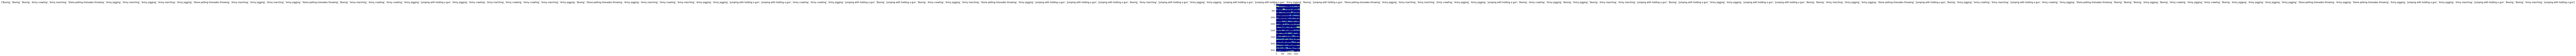

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
#torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

In [13]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [14]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [15]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(2048,n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 7)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 7.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [22]:
model_hybrid = torchvision.models.resnet50(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(2048, 2048), torch.nn.ReLU(), nn.Linear(2048, 7))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [25]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        
        train_loss_values = []
        train_acc_values = []
        val_loss_values = []
        val_acc_values = []
        
        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                if phase == 'train':
                    train_loss_values.append(epoch_loss)
                    train_acc_values.append(epoch_acc)
                else:
                    val_loss_values.append(epoch_loss)
                    val_acc_values.append(epoch_acc)
                    
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        epochs = range(1,len(train_acc_values)+1)
        plt.figure()
        plt.plot(epochs, train_acc_values, 'b', label = 'Training accuracy')
        plt.plot(epochs, val_acc_values, 'r', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig('Accuracyccsrnf.jpg')
        plt.figure()
        plt.plot(epochs, train_loss_values, 'b', label = 'Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig('Lossccsrnf.jpg')
        return model

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, num_classes, class_names):
    """
    Plots the confusion matrix for a multi-class classification model.

    Args:
        model (torch.nn.Module): Trained multi-class classification model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation or test dataset.
        num_classes (int): Number of classes in the dataset.
        class_names (list): List of class names.
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(num_classes+1, num_classes+1))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
# Assuming you have a trained multi-class classification model called 'model', a validation/test dataloader called 'val_dataloader',
# 7 classes, and a list of class names ['Crabs', 'Dolphin', 'Fish', 'Jelly_Fish', 'Lobster', 'Sea_Urchins', 'Starfish']
class_names = ['Crabs', 'Dolphin', 'Fish', 'Jelly_Fish', 'Lobster', 'Sea_Urchins', 'Starfish']
plot_confusion_matrix(model_hybrid, dataloaders['val'], num_classes=7, class_names=class_names)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve_multiclass(model, dataloader, num_classes):
    """
    Plots the ROC curve for a multi-class classification model.

    Args:
        model (torch.nn.Module): Trained multi-class classification model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation or test dataset.
        num_classes (int): Number of classes in the dataset.
    """
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve class %d (area = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Multi-Class)')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# Assuming you have a trained multi-class classification model called 'model', a validation/test dataloader called 'val_dataloader', and 7 classes
plot_roc_curve_multiclass(model_hybrid,  dataloaders['val'], num_classes=7)

In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['test'] // batch_size
it = 0

# Testing loop
for inputs, labels in dataloaders['test']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['test']
epoch_acc = running_corrects / dataset_sizes['test']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=8)